## 4.1 Coding an LLM architecture

In [74]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [2]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


output of model usually refers to as "logits", a DL jargon\
In DL, the last layer's output is called "logits"

each token is represented by a vec of dim 768, output 50257-dim vec\
train llm to 

## 4.2 Normalizing activations with layer normalization

from 2016, https://arxiv.org/abs/1607.06450\
normalize outputs to the next layer for a nice property for optimization

In [15]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [16]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

add nonlinearity, otherwise only linear combination won't be a useful neural network

In [18]:
out.mean()

tensor(0.1747, grad_fn=<MeanBackward0>)

mean of whole output, not useful

In [19]:
out.mean(dim=0)

tensor([0.2196, 0.2932, 0.0000, 0.3707, 0.1649, 0.0000],
       grad_fn=<MeanBackward1>)

mean of row vec (btw different examples)\
this's what batch normalization does\
but batch normalization is not recommended for llm, cause when training llm, we want to split it into different GPUs (e.g., split samples) which makes batch normalization unstable

layer normalization is independent of sample size\
normalize within examples

In [20]:
out.mean(dim=1)

tensor([0.1324, 0.2170], grad_fn=<MeanBackward1>)

In [21]:
out.mean(dim=-1)

tensor([0.1324, 0.2170], grad_fn=<MeanBackward1>)

dim=-1 is more robust, cause feature dimension is always the last

In [23]:
mean = out.mean(dim=-1, keepdim=True)
mean

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)

In [24]:
var = out.var(dim=-1, keepdim=True)
var

tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)

In [27]:
normed = (out - mean) / torch.sqrt(var)
normed

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim)) # scaling parameter
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) 
        # for regular embedding size, unbiased term doesn't make any difference
        # just an implementation, GPT-2 used tensorflow, default value is different
        norm_x = (x - mean) / torch.sqrt(var + self.eps) # eps prevents divide by 0
        return self.scale * norm_x + self.shift
        # network may learn scale to undo the division
        # offer another option

In [31]:
ln = LayerNorm(6)
outputs_normed = ln(out)
outputs_normed

tensor([[ 0.6745,  1.5470, -0.9549,  0.6431, -0.9549, -0.9549],
        [-0.0207,  0.1228, -1.1913,  1.6619,  0.6186, -1.1913]],
       grad_fn=<AddBackward0>)

In [32]:
outputs_normed.mean(dim=-1, keepdim=True)

tensor([[ 0.0000e+00],
        [-1.9868e-08]], grad_fn=<MeanBackward1>)

In [34]:
outputs_normed.var(dim=-1, keepdim=True)

tensor([[1.1994],
        [1.1996]], grad_fn=<VarBackward0>)

## 4.3 Implementing a feed forward network with GELU activations

GELU is a nonlinear activation fn\
many activation fn's\
GPT-2 uses GELU;\
llama uses swiglu

$$
\mathrm{GELU}(x)\approx 0.5\cdot x\cdot\left( 1+\tanh\left( \sqrt{\frac{x}{\pi}}cdot(x+0.044715\cdot x^3)  \right)  \right)
$$

In [35]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

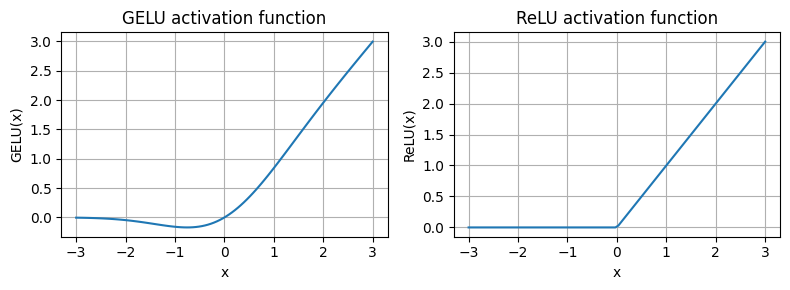

In [36]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # 768 -> 4*768
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

from small to large to small\
trick of DL:\
add parameters, parameters learn to extract information from input

Why 4 times?\
it's a hyperparameter\
original author of GPT-2 chose 4

In [38]:
ffn = FeedForward(GPT_CONFIG_124M)

In [39]:
x = torch.rand(2, 3, 768)

In [40]:
ffn(x).shape

torch.Size([2, 3, 768])

In [41]:
ffn.layers[0]

Linear(in_features=768, out_features=3072, bias=True)

In [42]:
ffn.layers[0].weight

Parameter containing:
tensor([[-0.0223,  0.0308,  0.0022,  ..., -0.0174, -0.0227, -0.0178],
        [-0.0027, -0.0043, -0.0274,  ...,  0.0079,  0.0112,  0.0010],
        [-0.0029,  0.0175,  0.0244,  ..., -0.0164, -0.0300,  0.0045],
        ...,
        [ 0.0255,  0.0023,  0.0277,  ..., -0.0037, -0.0134, -0.0284],
        [ 0.0266,  0.0236, -0.0193,  ...,  0.0120,  0.0061, -0.0261],
        [ 0.0222,  0.0106, -0.0190,  ..., -0.0253,  0.0320, -0.0109]],
       requires_grad=True)

## 4.4 Adding shortcut connections

comes from http://export.arxiv.org/pdf/1512.03385\
shortcut connection or residue connection\
add input into output

for very deep neural network, \
problem like explloding / vanishing gradients\
shortcut not diminish anything, 

In a deep neural network, without shortcuts, gradient is small\
back propagation is slow;
with shortcuts, gradients are larger

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut): # use_shortcut is a bool for experiment purpose
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output # no need to add shortcut to output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [45]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input) 

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [46]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169798612594604
layers.1.0.weight has gradient mean of 0.20694111287593842
layers.2.0.weight has gradient mean of 0.3289700150489807
layers.3.0.weight has gradient mean of 0.26657330989837646
layers.4.0.weight has gradient mean of 1.3258544206619263


## 4.5 Connecting attention and linear layers in a transformer block

token emmbedding: 1 -> 768;\
inputs;\
layernorm1;\
masked multihead attention;\
dropout;\
shortcut;\
layernorm2;\
ffn;\
dropout;\
shortcut;\
output

In [47]:
from modules import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"]) 
        # trainable parameters
        # different
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [48]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

In [49]:
x.shape

torch.Size([2, 4, 768])

In [50]:
output.shape

torch.Size([2, 4, 768])

## 4.6 Coding the GPT model

transformer block stacked 12 times\
12 is chosen by designer\
\
for example, 4 input tokens, output is 4 50257-dim vec (pdf), choose the token with largest probability\
input layer: token id -> embedding vec, i.e., vocabulary space -> emdedding space;\
output layer: emdedding space -> vocabulary space;

In [52]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [51]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [53]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)

In [54]:
batch.shape

torch.Size([2, 4])

In [55]:
out.shape

torch.Size([2, 4, 50257])

compute the number of elements

In [56]:
batch.numel()

8

In [59]:
total_params = sum(p.numel() for p in model.parameters())
total_params

163009536

In [62]:
print(f"{total_params:,}")

163,009,536


larger than 124M\
because in original GPT model, some weights are shared

In [63]:
model.tok_emb.weight.shape

torch.Size([50257, 768])

In [64]:
model.out_head.weight.shape

torch.Size([50257, 768])

might assume inverse mapping works well (bijective)

but many architectures don't:\
llama3.1 doean't;\
llama3.2 does\
\
not always leads to good results

In [65]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- **GPT2-small** (the 124M configuration we already implemented):
    - \"emb_dim\" = 768
    - \"n_layers\" = 12
    - \"n_heads\" = 12
- **GPT2-medium:**
    - \"emb_dim\" = 1024
    - \"n_layers\" = 24
    - \"n_heads\" = 16
- **GPT2-large:**
    - \"emb_dim\" = 1280
    - \"n_layers\" = 36
    - \"n_heads\" = 20
- **GPT2-XL:**
    - \"emb_dim\" = 1600
    - \"n_layers\" = 48
    - \"n_heads\" = 25"

In [ ]:
GPT_CONFIG_345M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1024,         # Embedding dimension
    "n_heads": 16,          # Number of attention heads
    "n_layers": 24,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
GPT_CONFIG_762M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1280,         # Embedding dimension
    "n_heads": 20,          # Number of attention heads
    "n_layers": 36,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
GPT_CONFIG_1542M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1600, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 25,          # Number of attention heads
    "n_layers": 48,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

## 4.7 Generating text

llm generate one word at a time\
\
train so right word has the highest probability

In [88]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # truncating

        with torch.no_grad(): # pytorch always builds cal. graph at background
            logits = model(idx_cond)
        logits = logits[:, -1, :] # last row

        probas = torch.softmax(logits, dim=-1)

        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # last dimension, not blend btw batches

        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [78]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
# add a batch dimension
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [71]:
encoded_tensor

tensor([[15496,    11,   314,   716]])

In [98]:
out = generate_text_simple(
    model=model, 
    idx=encoded_tensor, 
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"])

In [90]:
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 46895, 49555, 33000, 11867, 32999,  4348]])
Output length: 10


In [99]:
tokenizer.decode((out.squeeze(0)).tolist())

'Hello, I am677 discriminatedthey tripodamer1111'

model initialized randomly